In [1]:
import tensorflow as tf
model = tf.keras.models.load_model('model_epochs100_batch128')


2022-03-08 13:53:32.835555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 13:53:33.284797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 23)               47        
 n)                                                              
                                                                 
 layer1 (Dense)              (None, 11)                264       
                                                                 
 layer2 (Dense)              (None, 11)                132       
                                                                 
 output (Dense)              (None, 1)                 12        
                                                                 
Total params: 455
Trainable params: 408
Non-trainable params: 47
_________________________________________________________________


In [3]:
import glob
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
all_files = sorted(glob.glob(root+'outputs_multi/*.pkl'))

import pandas as pd
df = pd.read_pickle(root+'ML_data.pkl')


df_filtered = df.query('distance <= 1.0')


training_data = df_filtered.query('time < "2019-01-01 00:00:00"')
test_data = df_filtered.query('time >= "2020-01-01 00:00:00"')


features = ['sp', 'msl', 'u10', 'v10','t2m',
            'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
            'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
            'd2m', 'lsm', 'fal'] 
targets = ['MODIS_LST']

x_train = training_data[features]
y_train = training_data[targets]

x_test = test_data[features]
y_test = test_data[targets]

In [4]:
#Select 24 hours of test data
test_data_24 = test_data.query(' "2020-01-06 00:00:00" <= time < "2020-01-07 00:00:00"')


In [5]:
#Make some predictions, just for that 24 hours
predictions = model.predict(test_data_24[features])

2022-03-08 13:53:59.888616: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [16]:
#Create a simple df

df = test_data_24[['longitude_ERA', 'latitude_ERA', 'MODIS_LST']].copy()
df['predict'] = predictions
df['delta'] = df.MODIS_LST - df.predict

In [17]:
df

,longitude_ERA,latitude_ERA,MODIS_LST,predict,delta
48366892,-162.75,69.554988,238.599655,239.936905,-1.337250
48366893,-162.00,69.554988,237.633743,240.577164,-2.943420
48366894,-161.25,69.554988,239.007065,241.229202,-2.222137
48366895,-160.50,69.554988,235.139999,237.999039,-2.859039
48366896,-159.75,69.554988,231.563751,235.201797,-3.638046
...,...,...,...,...,...
48427437,65.25,-69.554988,264.316254,259.466278,4.849976
48427438,66.00,-69.554988,265.380005,261.079559,4.300446
48427439,66.75,-69.554988,266.256256,261.375153,4.881104
48427440,67.50,-69.554988,268.473755,262.178864,6.294891


In [13]:
import geopandas as gpd
def plot_map(df,x,y,q): #slow plotting function
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    

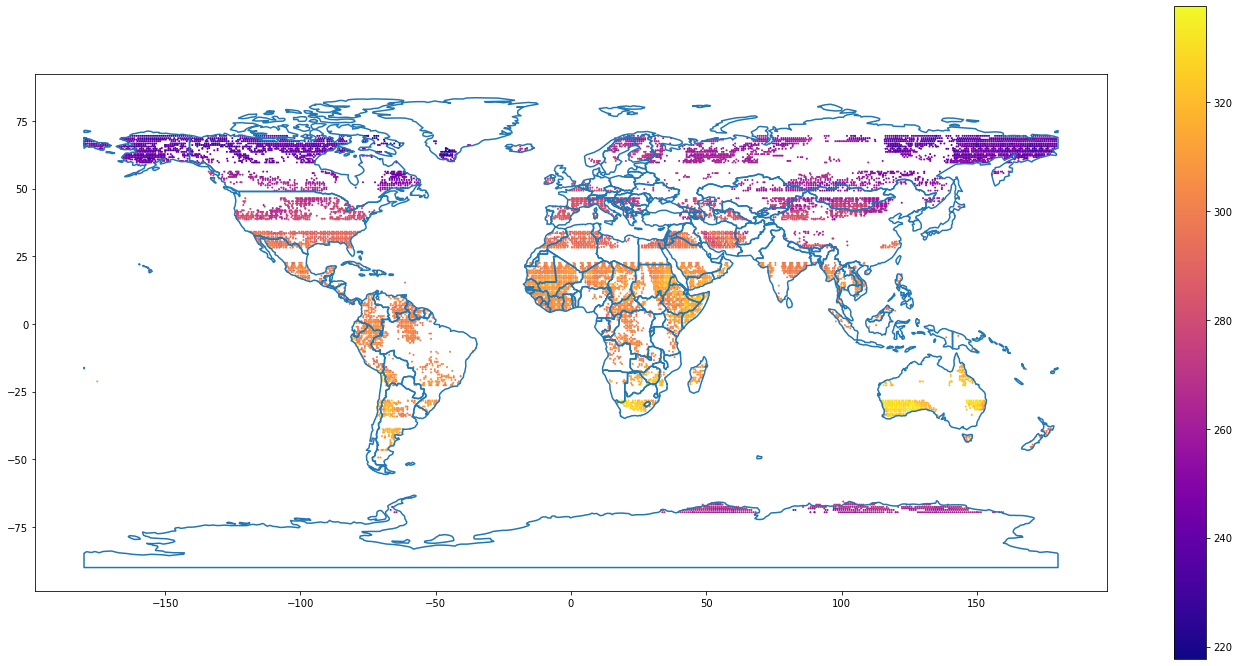

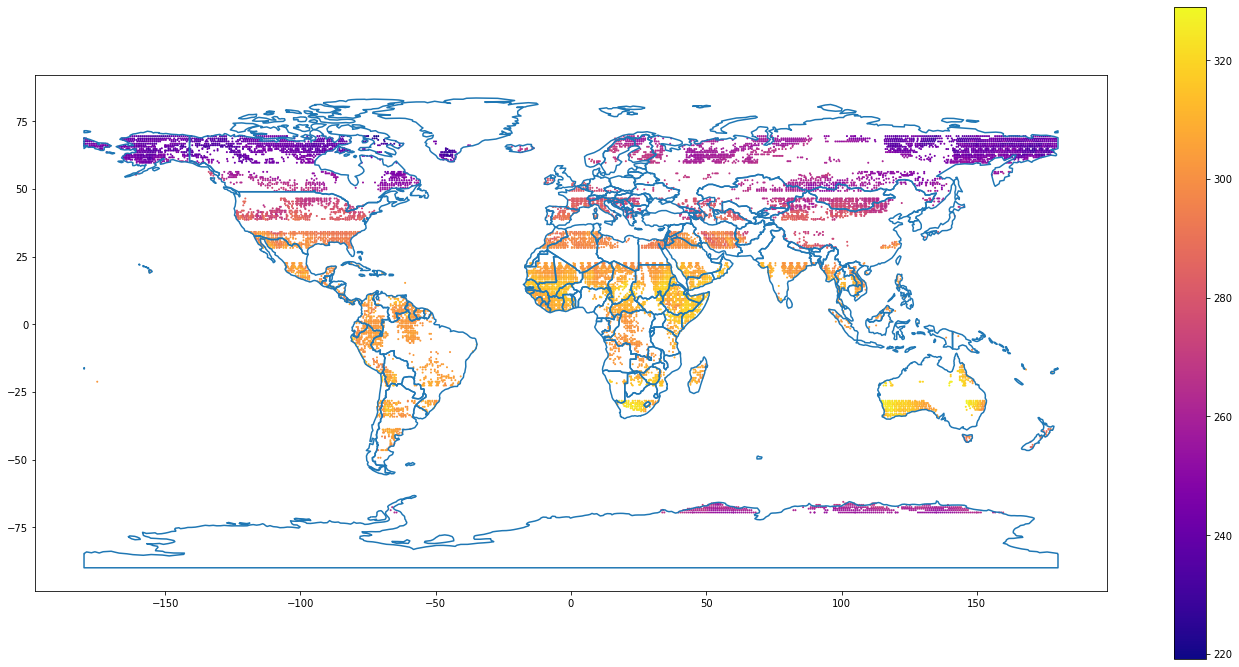

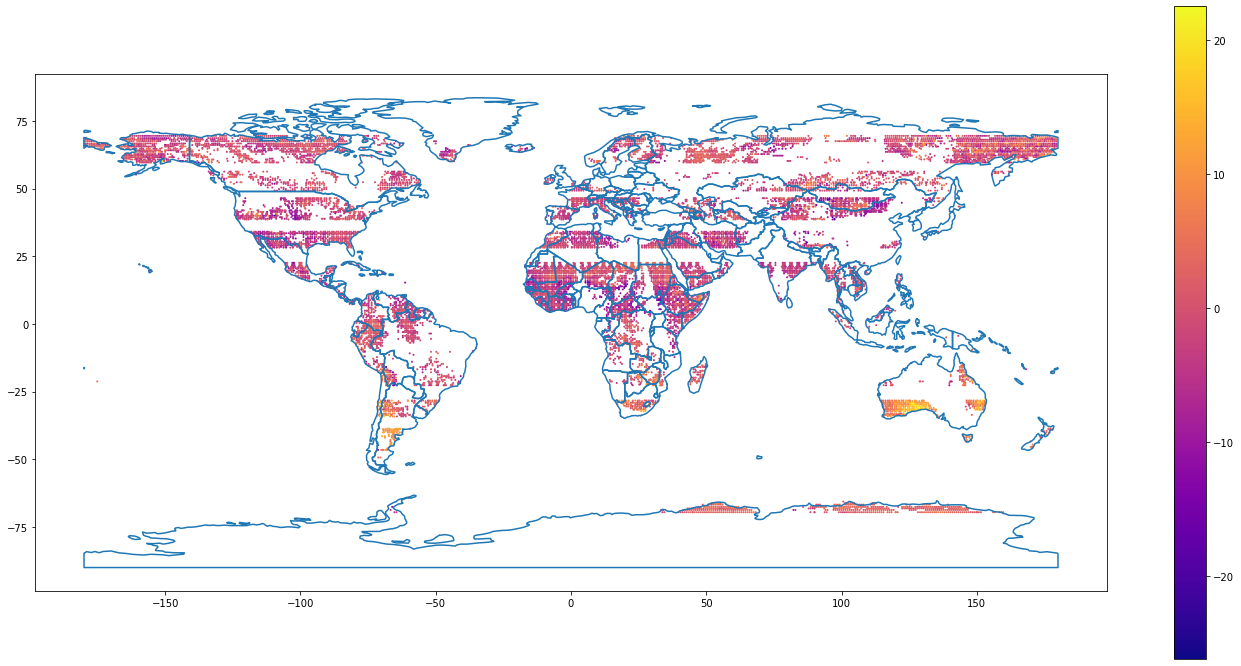

In [18]:
plot_map(df,'longitude_ERA', 'latitude_ERA', 'MODIS_LST')
plot_map(df,'longitude_ERA', 'latitude_ERA', 'predict')
plot_map(df,'longitude_ERA', 'latitude_ERA', 'delta')

In [21]:
df.delta.min()

-26.143555

<AxesSubplot:xlabel='longitude_ERA', ylabel='latitude_ERA'>

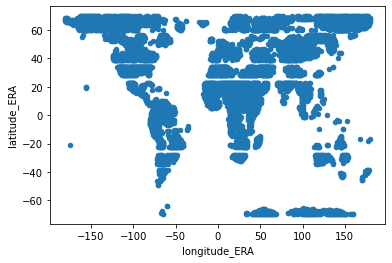

In [22]:
test_data_24.plot.scatter('longitude_ERA','latitude_ERA')